In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
import time
from pprint import pprint as pp
import sqlite3
import warnings
import numpy as np

warnings.filterwarnings('ignore')

# importing movie table
movies = pd.read_csv("movie_metadata.csv")
movies_large = pd.read_csv("movies_metadata.csv")

# create revenue column
movies["revenue"] = movies["gross"] - movies["budget"]

# create gross margin column
movies["gross_margin"] = movies["revenue"] / movies["gross"]

# success/failure column
#  defined as having a positive or negative gross margin
movies["successful"] = np.where(movies["gross_margin"] >= 0 , 1, 0)

# drop na values
movies = movies.dropna()

# decided to declare approved as PG. Not Rated, Passed and Unrated declared as 0 or null
movies["rating_numeric"] = movies["content_rating"].map({"G":1,"TV-G":1,"PG":2,"TV-PG":2,
                                                           "GP":2,"PG-13":3,"TV-14":3,"R":4,"TV-MA":4,
                                                           "M":4,"NC-17":5,"X":5,"Not Rated":0,"Approved":2,
                                                           "Unrated":0,"Passed":2})

# read in the second dataset and keep only the imdb id and the release date
movies_large = pd.read_csv("movies_metadata.csv")
movies_large = movies_large[["imdb_id", "release_date"]]
movies_large = movies_large.set_index("imdb_id")

In [2]:
# creating a star power score for director, actor 1, actor 2, and actor 3
#  identify how many times a name is in each column
#  find the average amount of times a name is in a column
#  divide the amount of times a name is in a column by the avg amount

# find director star power
directors = movies["director_name"].value_counts()
directors = directors.to_frame()
directoravg = directors["director_name"].mean()
directors["director_score"] = directors["director_name"] / directoravg
directors = directors[["director_score"]]


# actor 1 star power
actor1 = movies["actor_1_name"].value_counts()
actor1 = actor1.to_frame()
actor1avg = actor1["actor_1_name"].mean()
actor1["actor_1_score"] = actor1["actor_1_name"] / actor1avg
actor1 = actor1[["actor_1_score"]]

# actor 2 star power
actor2 = movies["actor_2_name"].value_counts()
actor2 = actor2.to_frame()
actor2avg = actor2["actor_2_name"].mean()
actor2["actor_2_score"] = actor2["actor_2_name"] / actor2avg
actor2 = actor2[["actor_2_score"]]

# actor 3 star power
actor3 = movies["actor_3_name"].value_counts()
actor3 = actor3.to_frame()
actor3avg = actor3["actor_3_name"].mean()
actor3["actor_3_score"] = actor3["actor_3_name"] / actor3avg
actor3 = actor3[["actor_3_score"]]


movies = movies.merge(directors, left_on="director_name", right_index=True)
movies = movies.merge(actor1, left_on="actor_1_name", right_index=True)
movies = movies.merge(actor2, left_on="actor_2_name", right_index=True)
movies = movies.merge(actor3, left_on="actor_3_name", right_index=True)


# pull the imdb code from the imdb link
movies["imdb_num_code"] = movies["movie_imdb_link"].str.split("/title/").str[1]
movies["imdb_num_code"] = movies["imdb_num_code"].str.split("\/\?ref").str[0]

movies = movies.merge(movies_large, left_on="imdb_num_code", 
                      right_index=True, how="inner")

# function to add additional definitions of success
#  may or may not be used
def success_key(x):
    if x >= .4:
        return "extreme success"
    elif x >= .3: 
        return "high success"
    elif x >= .2: 
        return "average success"
    elif x >= .1:
        return "moderate success"
    elif x >= .0:
        return "low success"
    else:
        return "no success"
    
movies["success_bins"] = movies["gross_margin"].apply(success_key)
movies.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,gross_margin,successful,rating_numeric,director_score,actor_1_score,actor_2_score,actor_3_score,imdb_num_code,release_date,success_bins
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,0.688365,1,3,3.091853,1.520767,1.747604,2.066294,tt0499549,2009-12-10,extreme success
1127,Color,Stephen Sommers,106.0,106.0,208.0,855.0,Jason Flemyng,3000.0,11146409.0,Action|Adventure|Horror|Sci-Fi,...,-3.037175,0,4,1.766773,3.041534,5.825346,2.066294,tt0118956,1998-01-30,no success
1699,Color,Terrence Malick,222.0,150.0,0.0,855.0,Michael Greyeyes,23000.0,12712093.0,Biography|Drama|History|Romance,...,-1.359958,0,3,1.325080,8.364217,0.582535,2.066294,tt0402399,2005-12-25,no success
747,Color,Brian Robbins,76.0,98.0,48.0,722.0,Joel David Moore,21000.0,61112916.0,Comedy|Family|Fantasy,...,0.181842,1,2,2.650160,9.884984,1.747604,2.066294,tt0393735,2006-03-09,moderate success
510,Color,Brad Peyton,178.0,94.0,62.0,722.0,Dwayne Johnson,14000.0,103812241.0,Action|Adventure|Comedy|Family|Fantasy|Sci-Fi,...,0.239011,1,2,1.325080,2.661342,1.747604,2.066294,tt1397514,2012-01-19,average success


In [4]:
# store dataframe in a sqlite db
con = sqlite3.connect("db/movies.db")
movie_data.to_sql("movie_data", con, if_exists="replace", index=False)
# commit the changes and close the connection
con.commit()
con.close()

In [ ]:
# CURRENTLY NOT WORKING....
# MEMORY LEAK AROUND LINE 2800

# retrieve the actual release date of every movie
# function to visit each provided url
#  scrape the release date
#  return it to be stored in a column
def get_release_date(url):
    data = requests.get(url).text
    time.sleep(2)
    soup = bs(data, "lxml")
    print(url)
    try:
        return soup.find(title="See more release dates").text.strip()
    except:
        print("no release date.")

# using the above function to create a release_date column
movies["release_date"] = movies["movie_imdb_link"].apply(get_release_date)

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
import time
from pprint import pprint as pp
import sqlite3
import warnings
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVC, SVR 
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings('ignore')


# read data from db into dataframe
con = sqlite3.connect("db/movies.db")

sql = f"""
   SELECT * FROM movie_data
   """

movie_data = pd.read_sql(sql, con)
movie_data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,gross_margin,successful,rating_numeric,director_score,actor_1_score,actor_2_score,actor_3_score,imdb_num_code,release_date,success_bins
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,0.688365,1,3,3.091853,1.520767,1.747604,2.066294,tt0499549,2009-12-10,extreme success
1,Color,Stephen Sommers,106.0,106.0,208.0,855.0,Jason Flemyng,3000.0,11146409.0,Action|Adventure|Horror|Sci-Fi,...,-3.037175,0,4,1.766773,3.041534,5.825346,2.066294,tt0118956,1998-01-30,no success
2,Color,Terrence Malick,222.0,150.0,0.0,855.0,Michael Greyeyes,23000.0,12712093.0,Biography|Drama|History|Romance,...,-1.359958,0,3,1.325080,8.364217,0.582535,2.066294,tt0402399,2005-12-25,no success
3,Color,Brian Robbins,76.0,98.0,48.0,722.0,Joel David Moore,21000.0,61112916.0,Comedy|Family|Fantasy,...,0.181842,1,2,2.650160,9.884984,1.747604,2.066294,tt0393735,2006-03-09,moderate success
4,Color,Brad Peyton,178.0,94.0,62.0,722.0,Dwayne Johnson,14000.0,103812241.0,Action|Adventure|Comedy|Family|Fantasy|Sci-Fi,...,0.239011,1,2,1.325080,2.661342,1.747604,2.066294,tt1397514,2012-01-19,average success


In [3]:
movie_data.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes', 'revenue',
       'gross_margin', 'successful', 'rating_numeric', 'director_score',
       'actor_1_score', 'actor_2_score', 'actor_3_score', 'imdb_num_code',
       'release_date', 'success_bins'],
      dtype='object')

In [12]:
X = movie_data[["director_score", "actor_1_score",
               "actor_2_score", "actor_3_score", "imdb_score"]]
y = movie_data["success_bins"].values.reshape(-1, 1)
print(X.shape, y.shape)

(3738, 5) (3738, 1)


In [13]:
# split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1158)
# Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### K Nearest Neighbor

k: 1, Train/Test Score: 0.953/0.397
k: 3, Train/Test Score: 0.656/0.404
k: 5, Train/Test Score: 0.601/0.436
k: 7, Train/Test Score: 0.591/0.468
k: 9, Train/Test Score: 0.576/0.478
k: 11, Train/Test Score: 0.565/0.486
k: 13, Train/Test Score: 0.556/0.496
k: 15, Train/Test Score: 0.543/0.493
k: 17, Train/Test Score: 0.532/0.491
k: 19, Train/Test Score: 0.531/0.501


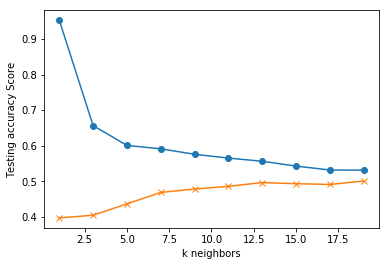

In [8]:
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [9]:
# 13 seems most stable
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train, y_train)
print('k=13 Test Acc: %.3f' % knn.score(X_test, y_test)) 

k=13 Test Acc: 0.474


### SVC

In [16]:
# linear classifier
# Fit to the training data and validate with the test data
model = SVC(kernel='linear')
model.fit(X_train, y_train)
predictions = model.predict(X_test)


 # Plot the decision boundaries
x_min = X[:, 0].min()
x_max = X[:, 0].max()
y_min = X[:, 1].min()
y_max = X[:, 1].max()

XX, YY = np.mgrid[x_min:x_max, y_min:y_max]
Z = model.decision_function(np.c_[XX.ravel(), YY.ravel()])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
# plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
            linestyles=['--', '-', '--'], levels=[-.5, 0, .5])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k', s=100)
plt.show()

TypeError: unhashable type: 'slice'

In [34]:
from sklearn.model_selection import GridSearchCV
modelGS = SVC(kernel='rbf')
param_grid = {'C': [.01, 1, 10, 100, 1000, 10000],
              'gamma': [0.0001,0.0005, 0.001,0.005, 0.01, 0.05]}
grid = GridSearchCV(modelGS, param_grid, verbose=2)

In [35]:
grid.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] C=0.01, gamma=0.0001 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. C=0.01, gamma=0.0001, total=   0.1s
[CV] C=0.01, gamma=0.0001 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ............................. C=0.01, gamma=0.0001, total=   0.1s
[CV] C=0.01, gamma=0.0001 ............................................
[CV] ............................. C=0.01, gamma=0.0001, total=   0.1s
[CV] C=0.01, gamma=0.0005 ............................................
[CV] ............................. C=0.01, gamma=0.0005, total=   0.1s
[CV] C=0.01, gamma=0.0005 ............................................
[CV] ............................. C=0.01, gamma=0.0005, total=   0.1s
[CV] C=0.01, gamma=0.0005 ............................................
[CV] ............................. C=0.01, gamma=0.0005, total=   0.1s
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............................. C=0.01, gamma=0.001, total=   0.1s
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............................. C=0.01, gamma=0.001, total=   0.1s
[CV] C=0.01, gamma=0.001 .............................................
[CV] .

[CV] .............................. C=100, gamma=0.0005, total=   0.2s
[CV] C=100, gamma=0.001 ..............................................
[CV] ............................... C=100, gamma=0.001, total=   0.2s
[CV] C=100, gamma=0.001 ..............................................
[CV] ............................... C=100, gamma=0.001, total=   0.2s
[CV] C=100, gamma=0.001 ..............................................
[CV] ............................... C=100, gamma=0.001, total=   0.2s
[CV] C=100, gamma=0.005 ..............................................
[CV] ............................... C=100, gamma=0.005, total=   1.3s
[CV] C=100, gamma=0.005 ..............................................
[CV] ............................... C=100, gamma=0.005, total=   1.4s
[CV] C=100, gamma=0.005 ..............................................
[CV] ............................... C=100, gamma=0.005, total=   1.3s
[CV] C=100, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  8.8min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.01, 1, 10, 100, 1000, 10000], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [36]:
# best parameters and score for the data
print(grid.best_params_)
print(grid.best_score_)

{'C': 1000, 'gamma': 0.01}
0.5094541562611488


In [20]:
import time
x = '2010-10-29'
print(time.strftime("%A", time.strptime(x, "%Y-%m-%d")))

Friday


In [1]:
import pandas as pd
import sqlite3

con = sqlite3.connect("db/movies.db")

sql = f"""
   SELECT * FROM movie_data
   """

movie_data = pd.read_sql(sql, con)
movie_data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,production_companies_count,genres_count,popularity,vote_count,vote_average,total_actor_starpower,release_month,holiday_month,tot_noms,tot_wins
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,4.0,4,185.070892,12114.0,7.2,5.334665,12,1,0,0
1,Color,Stephen Sommers,106.0,106.0,208.0,855.0,Jason Flemyng,3000.0,11146409.0,Action|Adventure|Horror|Sci-Fi,...,3.0,4,6.922458,155.0,6.0,10.933174,01,0,0,0
2,Color,Terrence Malick,222.0,150.0,0.0,855.0,Michael Greyeyes,23000.0,12712093.0,Biography|Drama|History|Romance,...,5.0,3,7.694502,336.0,6.4,11.013046,12,1,0,0
3,Color,Brian Robbins,76.0,98.0,48.0,722.0,Joel David Moore,21000.0,61112916.0,Comedy|Family|Fantasy,...,3.0,2,4.878907,138.0,4.5,13.698882,03,0,1,0
4,Color,Brad Peyton,178.0,94.0,62.0,722.0,Dwayne Johnson,14000.0,103812241.0,Action|Adventure|Comedy|Family|Fantasy|Sci-Fi,...,3.0,3,9.46307,1050.0,5.8,6.475240,01,0,0,0


In [2]:
movie_data["release_month"] = movie_data["release_date"].str.split("-").str[1]
movie_data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,imdb_num_code,release_date,success_bins,production_companies_count,genres_count,popularity,vote_count,vote_average,total_actor_starpower,release_month
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,tt0499549,2009-12-10,extreme success,4.0,4,185.070892,12114.0,7.2,5.334665,12
1,Color,Stephen Sommers,106.0,106.0,208.0,855.0,Jason Flemyng,3000.0,11146409.0,Action|Adventure|Horror|Sci-Fi,...,tt0118956,1998-01-30,no success,3.0,4,6.922458,155.0,6.0,10.933174,01
2,Color,Terrence Malick,222.0,150.0,0.0,855.0,Michael Greyeyes,23000.0,12712093.0,Biography|Drama|History|Romance,...,tt0402399,2005-12-25,no success,5.0,3,7.694502,336.0,6.4,11.013046,12
3,Color,Brian Robbins,76.0,98.0,48.0,722.0,Joel David Moore,21000.0,61112916.0,Comedy|Family|Fantasy,...,tt0393735,2006-03-09,moderate success,3.0,2,4.878907,138.0,4.5,13.698882,03
4,Color,Brad Peyton,178.0,94.0,62.0,722.0,Dwayne Johnson,14000.0,103812241.0,Action|Adventure|Comedy|Family|Fantasy|Sci-Fi,...,tt1397514,2012-01-19,average success,3.0,3,9.46307,1050.0,5.8,6.475240,01


In [3]:
def find_holiday(x):
    if x == "2" or x == "11" or x == "12":
        return 1
    else:
        return 0
    
movie_data["holiday_month"] = movie_data["release_month"].apply(find_holiday)

movie_data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,release_date,success_bins,production_companies_count,genres_count,popularity,vote_count,vote_average,total_actor_starpower,release_month,holiday_month
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,2009-12-10,extreme success,4.0,4,185.070892,12114.0,7.2,5.334665,12,1
1,Color,Stephen Sommers,106.0,106.0,208.0,855.0,Jason Flemyng,3000.0,11146409.0,Action|Adventure|Horror|Sci-Fi,...,1998-01-30,no success,3.0,4,6.922458,155.0,6.0,10.933174,01,0
2,Color,Terrence Malick,222.0,150.0,0.0,855.0,Michael Greyeyes,23000.0,12712093.0,Biography|Drama|History|Romance,...,2005-12-25,no success,5.0,3,7.694502,336.0,6.4,11.013046,12,1
3,Color,Brian Robbins,76.0,98.0,48.0,722.0,Joel David Moore,21000.0,61112916.0,Comedy|Family|Fantasy,...,2006-03-09,moderate success,3.0,2,4.878907,138.0,4.5,13.698882,03,0
4,Color,Brad Peyton,178.0,94.0,62.0,722.0,Dwayne Johnson,14000.0,103812241.0,Action|Adventure|Comedy|Family|Fantasy|Sci-Fi,...,2012-01-19,average success,3.0,3,9.46307,1050.0,5.8,6.475240,01,0


In [3]:
for i in movie_data.columns:
    print(i)

color
director_name
num_critic_for_reviews
duration
director_facebook_likes
actor_3_facebook_likes
actor_2_name
actor_1_facebook_likes
gross
genres
actor_1_name
movie_title
num_voted_users
cast_total_facebook_likes
actor_3_name
facenumber_in_poster
plot_keywords
movie_imdb_link
num_user_for_reviews
language
country
content_rating
budget
title_year
actor_2_facebook_likes
imdb_score
aspect_ratio
movie_facebook_likes
revenue
gross_margin
successful
rating_numeric
director_score
actor_1_score
actor_2_score
actor_3_score
imdb_num_code
release_date
success_bins
production_companies_count
genres_count
popularity
vote_count
vote_average
total_actor_starpower
release_month
holiday_month
tot_noms
tot_wins


In [5]:
# Assign X (data) and y (target)
X = movie_data[["rating_numeric","director_score","production_companies_count","total_actor_starpower","release_month",
             "tot_wins","tot_noms"]]
y = movie_data["successful"].values.reshape(-1, 1)
print(X.shape, y.shape)

(3637, 7) (3637, 1)


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
import numpy as np

warnings.filterwarnings('ignore')

# split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1158, train_size=0.80, stratify=y)

# Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)

# transform the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [12]:
from sklearn.neighbors import KNeighborsClassifier
#making the instance
model = KNeighborsClassifier(n_jobs=-1)
#learning
model.fit(X_train,y_train)
#Prediction
prediction=model.predict(X_test)
#importing the metrics module
from sklearn import metrics
#evaluation(Accuracy)
print("Accuracy:",metrics.accuracy_score(prediction,y_test))
#evaluation(Confusion Metrix)
print("Confusion Metrix:\n",metrics.confusion_matrix(prediction,y_test))

Accuracy: 0.5576923076923077
Confusion Metrix:
 [[146 130]
 [192 260]]


In [14]:
#With Hyper Parameters Tuning
#2-4,kNearestNeighbors
#importing modules
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
#making the instance
model = KNeighborsClassifier(n_jobs=-1)
#Hyper Parameters Set
params = {'n_neighbors':[5,6,7,8,9,10],
          'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'n_jobs':[-1]}
#Making models with hyper parameters sets
model1 = GridSearchCV(model, param_grid=params, n_jobs=1)
#Learning
model1.fit(X_train,y_train)
#The best hyper parameters set
print("Best Hyper Parameters:\n",model1.best_params_)
#Prediction
prediction=model1.predict(X_test)
#importing the metrics module
from sklearn import metrics
#evaluation(Accuracy)
print("Accuracy:",metrics.accuracy_score(prediction,y_test))
#evaluation(Confusion Metrix)
print("Confusion Metrix:\n",metrics.confusion_matrix(prediction,y_test))

Best Hyper Parameters:
 {'algorithm': 'auto', 'leaf_size': 2, 'n_jobs': -1, 'n_neighbors': 10, 'weights': 'distance'}
Accuracy: 0.5521978021978022
Confusion Metrix:
 [[145 133]
 [193 257]]
